<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install einops

100%|██████████| 9912422/9912422 [00:00<00:00, 313173877.22it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47006478.01it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 126227735.43it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20331407.44it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

torch.Size([100, 1, 28, 28]) torch.Size([100])


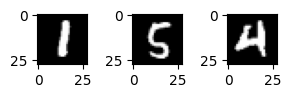

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from einops.layers.torch import Reduce
import ipdb

device = "cuda" if torch.cuda.is_available() else "cpu"

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5],std=[0.5])])
dataset = datasets.MNIST(root="dataset/", transform=trans, download=True, train=True) # 6W张图片 1,28,28
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(image.shape, label.shape) # 100,1,28,28; 100

fig, axs = plt.subplots(1, 3, figsize=(3, 1))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(image[i][0].cpu(), cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
# https://www.jianshu.com/p/06a40338dc7c
class PatchEmbedding(nn.Module):
  def __init__(self, patch_size: int = 4, emb_size: int = 40, img_size: int = 28):
      self.patch_size = patch_size
      super().__init__()
      self.conv = nn.Conv2d(1, emb_size, kernel_size=patch_size, stride=patch_size)
      self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) # 1,1,40
      self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size)) # 50,40

  def forward(self, x):
      b, _, _, _ = x.shape # 100,1,28,28
      x = self.conv(x) # => 100,40,7,7
      x = rearrange(x, 'b e (h) (w) -> b (h w) e') # => 100,49,40
      cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
      x = torch.cat([cls_tokens, x], dim=1) # => 100,50,40
      x += self.positions
      return x # 100,50,40

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size: int = 40, num_heads: int = 4, dropout: float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.qkv = nn.Linear(emb_size, emb_size * 3)
    self.att_drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x):
    x = self.qkv(x) # 100,50,40 => 100,50,120
    qkv = rearrange(x, "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3) # => 3,100,4,50,10
    queries, keys, values = qkv[0], qkv[1], qkv[2] # => 100,4,50,10
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # => 100,4,50,50
    scaling = self.emb_size ** (1/2)
    att = nn.functional.softmax(energy, dim=-1) / scaling
    att = self.att_drop(att)

    out = torch.einsum('bhal, bhlv -> bhav ', att, values) # => 100,4,50,10
    out = rearrange(out, "b h n d -> b n (h d)") # => 100,50,40
    out = self.projection(out) # => 100,50,40
    return out

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x):
    res = x
    x = self.fn(x)
    x += res
    return x

class FeedForwardBlock(nn.Sequential):
  def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
    super().__init__(
      nn.Linear(emb_size, expansion * emb_size),
      nn.GELU(),
      nn.Dropout(drop_p),
      nn.Linear(expansion * emb_size, emb_size),
    )

class TransformerEncoderBlock(nn.Sequential):
  def __init__(self,emb_size: int = 40,drop_p: float = 0.):
    super().__init__(
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        MultiHeadAttention(),
        nn.Dropout(drop_p)
      )),
      ResidualAdd(nn.Sequential(
        nn.LayerNorm(emb_size),
        FeedForwardBlock(emb_size),
        nn.Dropout(drop_p)
      )
      ))

class TransformerEncoder(nn.Sequential):
  def __init__(self, depth: int = 12):
    super().__init__(*[TransformerEncoderBlock() for _ in range(depth)])

class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size: int = 40, n_classes: int = 10):
    super().__init__(
      Reduce('b n e -> b e', reduction='mean'), # 100,50,40 => 100,40
      nn.LayerNorm(emb_size),
      nn.Linear(emb_size, n_classes)) # 100,40 => 100,10

class ViT(nn.Sequential):
  def __init__(self):
    super().__init__(
      PatchEmbedding(),
      TransformerEncoder(),
      ClassificationHead()
    )

In [7]:
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for epoch in range(1,4):
  total_loss = []
  errorTotal = 0
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())
    maxV,maxIdx = outputs.max(dim=1)
    errorNum = torch.sum(torch.ne(maxIdx, label)).item()
    errorTotal += errorNum

    if(batch_idx % 100 == 99):
      print("epoch:{} batch:{} loss:{:.2f} mean:{:.2f} error:{}/100 errorTotal:{}/{} {:.2f}%".format(
          epoch, batch_idx, loss, np.mean(total_loss), errorNum, errorTotal, (batch_idx+1) * 100, errorTotal / (batch_idx+1)))

epoch:1 batch:99 loss:2.11 mean:2.26 error:73/100 errorTotal:8317/10000 83.17%
epoch:1 batch:199 loss:1.23 mean:1.95 error:29/100 errorTotal:13518/20000 67.59%
epoch:1 batch:299 loss:0.91 mean:1.66 error:23/100 errorTotal:16167/30000 53.89%
epoch:1 batch:399 loss:0.76 mean:1.45 error:20/100 errorTotal:18011/40000 45.03%
epoch:1 batch:499 loss:0.74 mean:1.30 error:21/100 errorTotal:19479/50000 38.96%
epoch:1 batch:599 loss:0.53 mean:1.18 error:12/100 errorTotal:20752/60000 34.59%
epoch:2 batch:99 loss:0.54 mean:0.53 error:11/100 errorTotal:1109/10000 11.09%
epoch:2 batch:199 loss:0.56 mean:0.51 error:14/100 errorTotal:2154/20000 10.77%
epoch:2 batch:299 loss:0.46 mean:0.48 error:11/100 errorTotal:3149/30000 10.50%
epoch:2 batch:399 loss:0.34 mean:0.46 error:9/100 errorTotal:4041/40000 10.10%
epoch:2 batch:499 loss:0.36 mean:0.44 error:10/100 errorTotal:4850/50000 9.70%
epoch:2 batch:599 loss:0.28 mean:0.42 error:6/100 errorTotal:5639/60000 9.40%
epoch:3 batch:99 loss:0.39 mean:0.31 erro

In [8]:
trans_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5],std=[0.5])])
dataset_test = datasets.MNIST(root="dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
criterion_test = nn.CrossEntropyLoss()

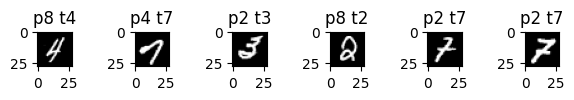

batch:9 loss:0.27 mean:0.22 error:6/100 errorTotal:52/1000 5.20%


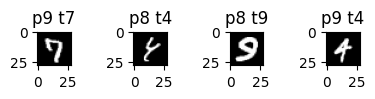

batch:19 loss:0.27 mean:0.23 error:4/100 errorTotal:100/2000 5.00%


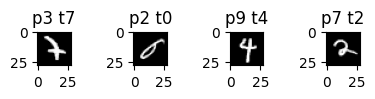

batch:29 loss:0.26 mean:0.23 error:4/100 errorTotal:155/3000 5.17%


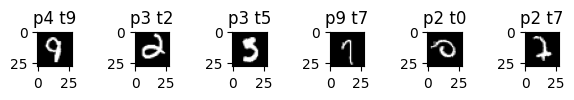

batch:39 loss:0.27 mean:0.24 error:6/100 errorTotal:225/4000 5.62%


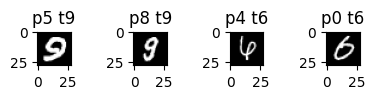

batch:49 loss:0.24 mean:0.25 error:4/100 errorTotal:283/5000 5.66%


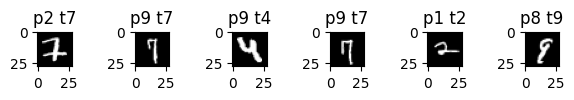

batch:59 loss:0.28 mean:0.25 error:6/100 errorTotal:345/6000 5.75%


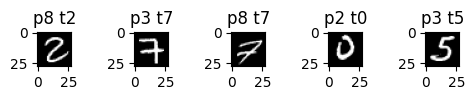

batch:69 loss:0.23 mean:0.24 error:5/100 errorTotal:393/7000 5.61%


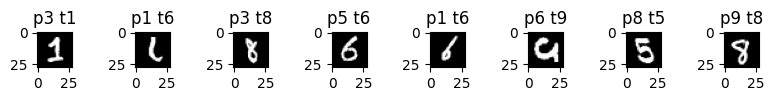

batch:79 loss:0.34 mean:0.24 error:8/100 errorTotal:449/8000 5.61%


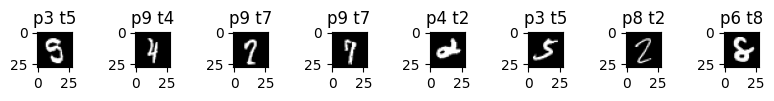

batch:89 loss:0.31 mean:0.24 error:8/100 errorTotal:499/9000 5.54%


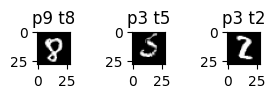

batch:99 loss:0.20 mean:0.24 error:3/100 errorTotal:554/10000 5.54%


In [9]:
total_loss = []
errorTotal = 0
for batch_idx, (img, label) in enumerate(loader_test): # 1W张图片, 100批, 100,1,28,28
  img = img.to(device)
  label = label.to(device)

  output = model(img)
  loss = criterion_test(output, label)
  total_loss.append(loss.item())

  maxV,maxIdx = output.max(dim=1)
  errorNum = torch.sum(torch.ne(maxIdx, label)).item()
  errorTotal += errorNum

  noMatchIdx = torch.nonzero(torch.ne(maxIdx, label)).view(-1)

  if(batch_idx % 10 == 9):
    if errorNum > 8:
      errorNum = 8
    fig, axs = plt.subplots(1, errorNum, figsize=(errorNum, 1))
    for i, ax in enumerate(axs.flatten()):
      idx = noMatchIdx[i]
      ax.imshow(img[idx][0].cpu(), cmap='gray')
      ax.set_title('p{} t{}'.format(maxIdx[idx], label[idx]))
    plt.tight_layout()
    plt.show()
    print("batch:{} loss:{:.2f} mean:{:.2f} error:{}/100 errorTotal:{}/{} {:.2f}%".format(
        batch_idx, loss, np.mean(total_loss), errorNum, errorTotal, (batch_idx+1) * 100, errorTotal / (batch_idx+1)))